<a href="https://colab.research.google.com/github/brainapp12/CodeLlama-via-DeepInfra/blob/main/undersampling_bagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification on imbalanced data with undersampling + bagging

cf. https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
import random
import numpy as np
import tensorflow as tf

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



In [ ]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)

In [ ]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [ ]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

undersamplingをしない場合の性能

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

neg, pos = np.bincount(train_labels)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
train_f_count = neg
train_t_count = pos

classifier = RandomForestClassifier(
    random_state = 42,
    n_jobs = -1
)

classifier.fit(train_df, train_labels)

Examples:
    Total: 182276
    Positive: 330 (0.18% of total)



RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
train_predictions_undersampled = classifier.predict_proba(train_df)
test_predictions_undersampled = classifier.predict_proba(test_df)
train_predictions_undersampled_proba_t = train_predictions_undersampled.T[1]
test_predictions_undersampled_proba_t = test_predictions_undersampled.T[1]

Legitimate Transactions Detected (True Negatives):  56860
Legitimate Transactions Incorrectly Detected (False Positives):  4
Fraudulent Transactions Missed (False Negatives):  22
Fraudulent Transactions Detected (True Positives):  76
Total Fraudulent Transactions:  98


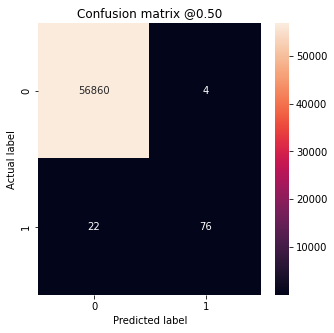

In [ ]:
plot_cm(test_labels, test_predictions_undersampled_proba_t)

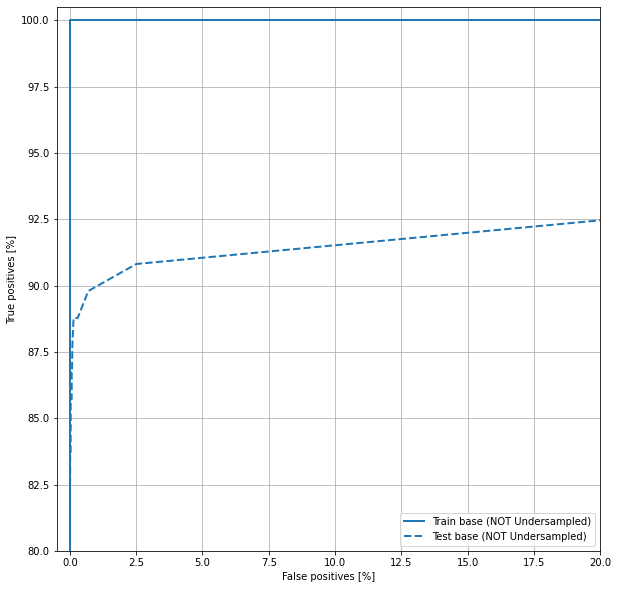

In [ ]:
plot_roc("Train base (NOT Undersampled)", train_labels, train_predictions_undersampled_proba_t, color=colors[0])
plot_roc("Test base (NOT Undersampled)", test_labels, test_predictions_undersampled_proba_t, color=colors[0], linestyle='--')

plt.legend(loc='lower right');

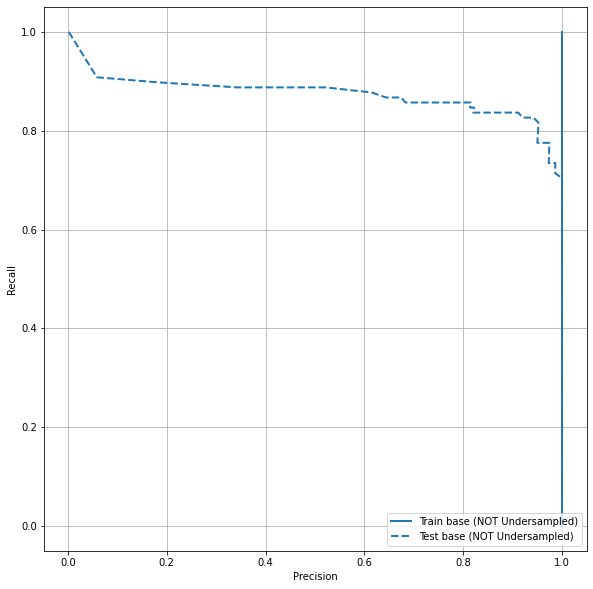

In [ ]:
plot_prc("Train base (NOT Undersampled)", train_labels, train_predictions_undersampled_proba_t, color=colors[0])
plot_prc("Test base (NOT Undersampled)", test_labels, test_predictions_undersampled_proba_t, color=colors[0], linestyle='--')

plt.legend(loc='lower right');

In [ ]:
from sklearn.metrics import confusion_matrix, make_scorer

def cm_tp(y, y_pred, **kwargs):
  tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
  return tp
def cm_fp(y, y_pred, **kwargs):
  # cm = confusion_matrix(y, y_pred)
  tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
  return fp
def cm_tn(y, y_pred, **kwargs):
  tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
  return tn
def cm_fn(y, y_pred, **kwargs):
  tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
  return fn

tp_scorer = make_scorer(cm_tp)
fp_scorer = make_scorer(cm_fp)
tn_scorer = make_scorer(cm_tn)
fn_scorer = make_scorer(cm_fn)

scoring = {
    "f1": "f1",
    "precision": "precision",
    "recall": "recall",
    "tp": tp_scorer,
    "fp": fp_scorer,
    "tn": tn_scorer,
    "fn": fn_scorer,
}

undersampling実施。

負例をどのくらい減らすかのratioを1〜0.01でグリッドサーチしてみる。

In [ ]:
# そこそこ時間が掛かるので、一度試したらコメントアウトしたほうが良い

from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# ratios = [1, 1.45, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 16, 20]
ratios = [1, 0.75, 0.5, 0.25, 0.125, 0.05, 0.01]
parameters = {'n_estimators': [100]}


neg, pos = np.bincount(train_labels)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
train_f_count = neg
train_t_count = pos


rus_results = dict()
for n, ratio in enumerate(ratios):
  under_sampling_rate = ratio
  sampler = RandomUnderSampler(
      sampling_strategy = {0 : int(train_f_count * under_sampling_rate), 1 : train_t_count},
      random_state = 42
  )

  # sampler = RandomUnderSampler(
  #     sampling_strategy = {0 : int(train_t_count * under_sampling_rate), 1 : train_t_count},
  #     random_state = 42
  # )

  train_res_df, train_res_labels = sampler.fit_resample(train_df, train_labels)

  model = RandomForestClassifier(
      random_state = 42,
      n_jobs = -1
  )

  tree_grid_search = GridSearchCV(model, param_grid=parameters, verbose=2, n_jobs=-1, cv=5, return_train_score=True, scoring = scoring, refit=False)
  tree_grid_search.fit(train_res_df, train_res_labels)
  rus_results[ratio] = tree_grid_search


Examples:
    Total: 182276
    Positive: 330 (0.18% of total)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


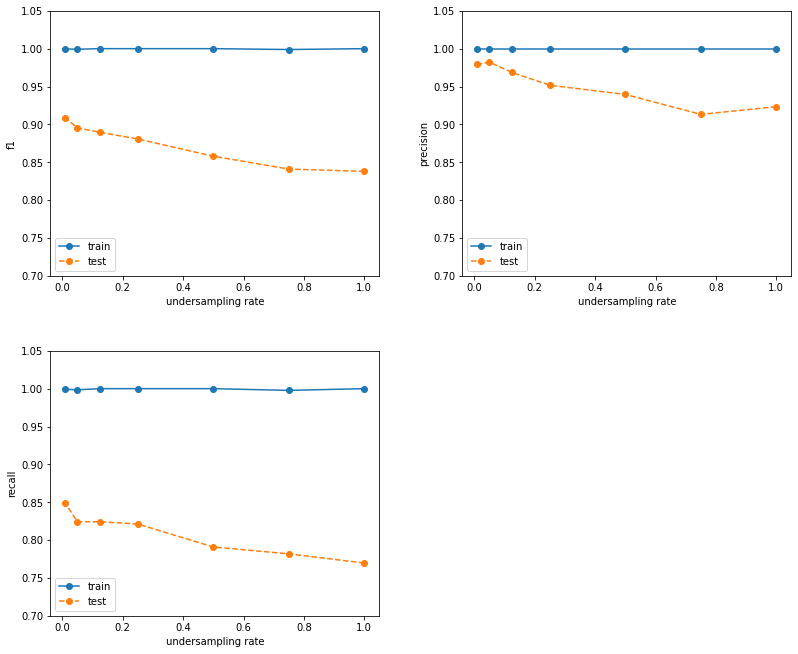

In [ ]:
def plot_results(result_dict, ratios, metrics, param = 'class_ratio', name = 'undersampling rate'):
  for n, metric in enumerate(metrics):
    train_scores = np.array([])
    test_scores = np.array([])
    for rr, ratio in enumerate(ratios):
      model = result_dict[ratio]
      train_score = model.cv_results_['mean_train_%s' % metric]
      train_scores = np.append(train_scores, train_score)
      test_score = model.cv_results_['mean_test_%s' % metric]
      test_scores = np.append(test_scores, test_score)

    param_values = ratios
    plt.subplot(2, 2, n+1)
    plt.plot(param_values, train_scores, 'o', color=colors[0], linestyle="-", label = 'train')
    plt.plot(param_values, test_scores, 'o', color=colors[1], linestyle="--", label = 'test')

    plt.xlabel(name)
    plt.ylabel(metric)
    if metric in ["precision"]:
      plt.ylim([0.7, 1.05])
    elif metric in ["f1", "recall"]:
      plt.ylim([0.7, 1.05])

    plt.legend()
    plt.tight_layout(pad = 4)

plot_results(rus_results, ratios, ["f1", "precision", "recall",])

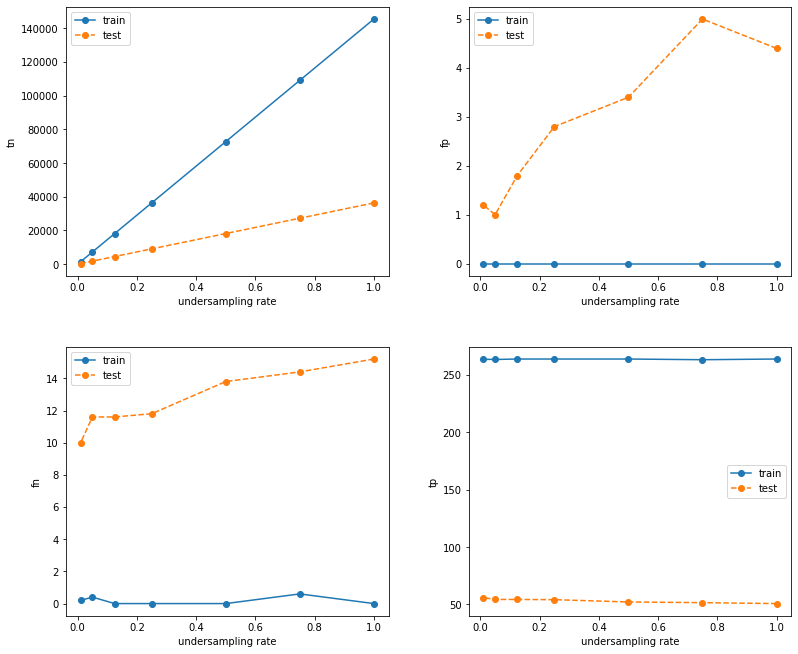

In [ ]:
plot_results(rus_results, ratios, ["tn", "fp", "fn", "tp",])

ratioが小さくなるほど、f1, precision, recallが向上する傾向にあった。

訓練データの負例181,946個の0.01倍は1,819個で、これは正例330個の5.51倍に相当するので、1から10のratioで再度グリッドサーチする。

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

ratios = [1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10]
# ratios = [1, 0.75, 0.5, 0.25, 0.125, 0.05, 0.01]
parameters = {'n_estimators': [100]}


neg, pos = np.bincount(train_labels)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
train_f_count = neg
train_t_count = pos


rus_results = dict()
for n, ratio in enumerate(ratios):
  under_sampling_rate = ratio
  # sampler = RandomUnderSampler(
  #     sampling_strategy = {0 : int(train_f_count * under_sampling_rate), 1 : train_t_count},
  #     random_state = 42
  # )

  sampler = RandomUnderSampler(
      sampling_strategy = {0 : int(train_t_count * under_sampling_rate), 1 : train_t_count},
      random_state = 42
  )

  train_res_df, train_res_labels = sampler.fit_resample(train_df, train_labels)

  model = RandomForestClassifier(
      random_state = 42,
      n_jobs = -1
  )

  tree_grid_search = GridSearchCV(model, param_grid=parameters, verbose=2, n_jobs=-1, cv=5, return_train_score=True, scoring = scoring, refit=False)
  tree_grid_search.fit(train_res_df, train_res_labels)
  rus_results[ratio] = tree_grid_search


Examples:
    Total: 182276
    Positive: 330 (0.18% of total)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


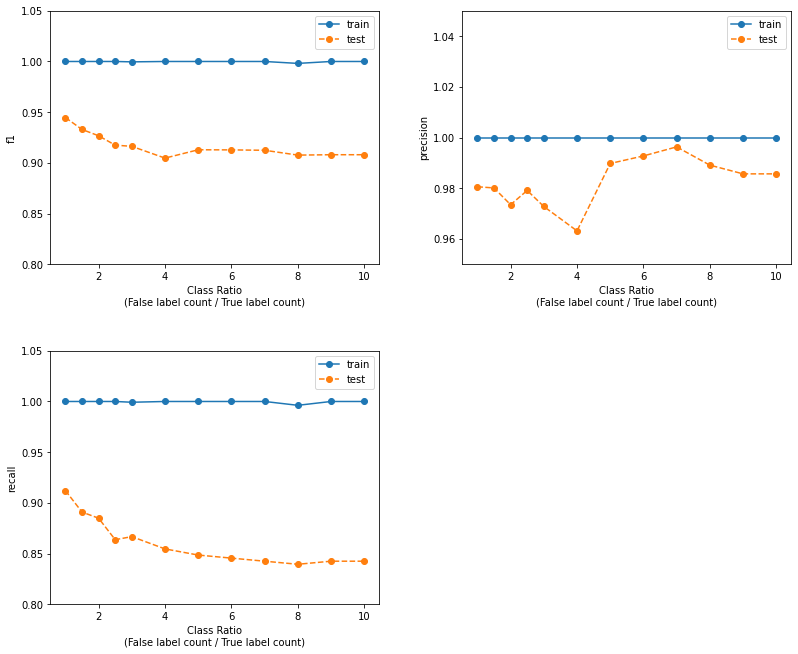

In [ ]:
def plot_results(result_dict, ratios, metrics, param = 'class_ratio', name = 'Class Ratio\n(False label count / True label count)'):
  for n, metric in enumerate(metrics):
    train_scores = np.array([])
    test_scores = np.array([])
    for rr, ratio in enumerate(ratios):
      model = result_dict[ratio]
      train_score = model.cv_results_['mean_train_%s' % metric]
      train_scores = np.append(train_scores, train_score)
      test_score = model.cv_results_['mean_test_%s' % metric]
      test_scores = np.append(test_scores, test_score)

    param_values = ratios
    plt.subplot(2, 2, n+1)
    plt.plot(param_values, train_scores, 'o', color=colors[0], linestyle="-", label = 'train')
    plt.plot(param_values, test_scores, 'o', color=colors[1], linestyle="--", label = 'test')

    plt.xlabel(name)
    plt.ylabel(metric)
    if metric in ["precision"]:
      plt.ylim([0.95, 1.05])
    elif metric in ["f1", "recall"]:
      plt.ylim([0.8, 1.05])

    plt.legend()
    plt.tight_layout(pad = 4)

plot_results(rus_results, ratios, ["f1", "precision", "recall",])

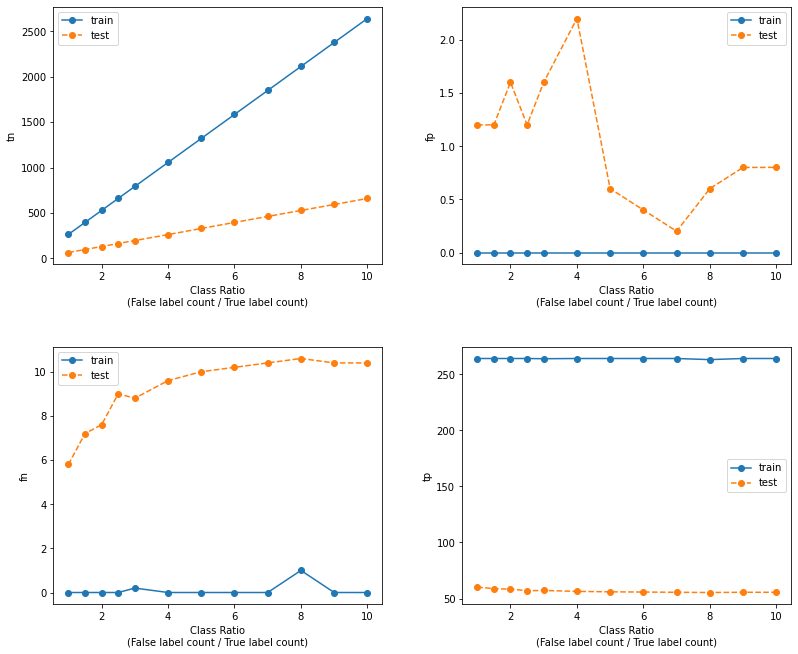

In [ ]:
plot_results(rus_results, ratios, ["tn", "fp", "fn", "tp",])

f1, recall重視であればratio=1を、precision重視であればratio=7を選択する。

ratio=1で性能を見てみる。

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

neg, pos = np.bincount(train_labels)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
train_f_count = neg
train_t_count = pos

under_sampling_rate = 1
sampler = RandomUnderSampler(
    sampling_strategy = {0 : int(train_t_count * under_sampling_rate), 1 : train_t_count},
    random_state = 42
)

classifier = RandomForestClassifier(
    random_state = 42,
    n_jobs = -1
)

train_res_df, train_res_labels = sampler.fit_resample(train_df, train_labels)
classifier.fit(train_res_df, train_res_labels)

Examples:
    Total: 182276
    Positive: 330 (0.18% of total)



RandomForestClassifier(n_jobs=-1, random_state=42)

Legitimate Transactions Detected (True Negatives):  55329
Legitimate Transactions Incorrectly Detected (False Positives):  1535
Fraudulent Transactions Missed (False Negatives):  8
Fraudulent Transactions Detected (True Positives):  90
Total Fraudulent Transactions:  98


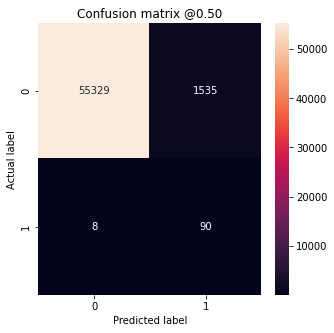

In [ ]:
train_predictions_undersampled_t1 = classifier.predict_proba(train_df)
test_predictions_undersampled_t1 = classifier.predict_proba(test_df)
train_predictions_undersampled_t1_proba_t = train_predictions_undersampled_t1.T[1]
test_predictions_undersampled_t1_proba_t = test_predictions_undersampled_t1.T[1]

plot_cm(test_labels, test_predictions_undersampled_t1_proba_t)


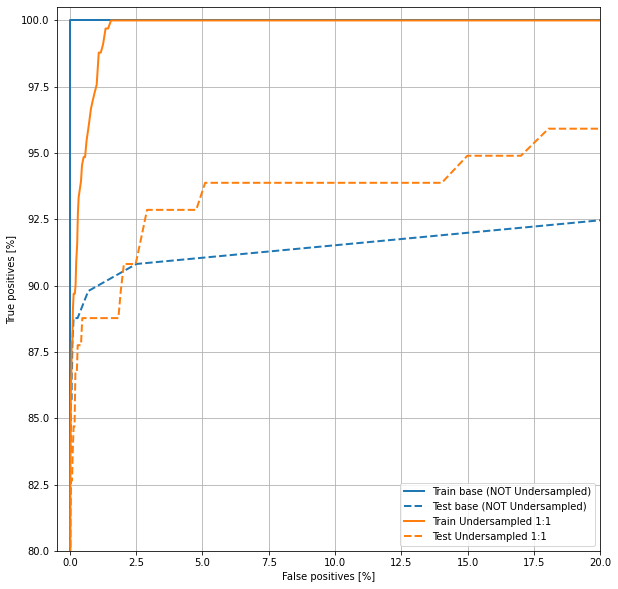

In [ ]:
plot_roc("Train base (NOT Undersampled)", train_labels, train_predictions_undersampled_proba_t, color=colors[0])
plot_roc("Test base (NOT Undersampled)", test_labels, test_predictions_undersampled_proba_t, color=colors[0], linestyle='--')

plot_roc("Train Undersampled 1:1", train_labels, train_predictions_undersampled_t1_proba_t, color=colors[1])
plot_roc("Test Undersampled 1:1", test_labels, test_predictions_undersampled_t1_proba_t, color=colors[1], linestyle='--')
plt.legend(loc='lower right');


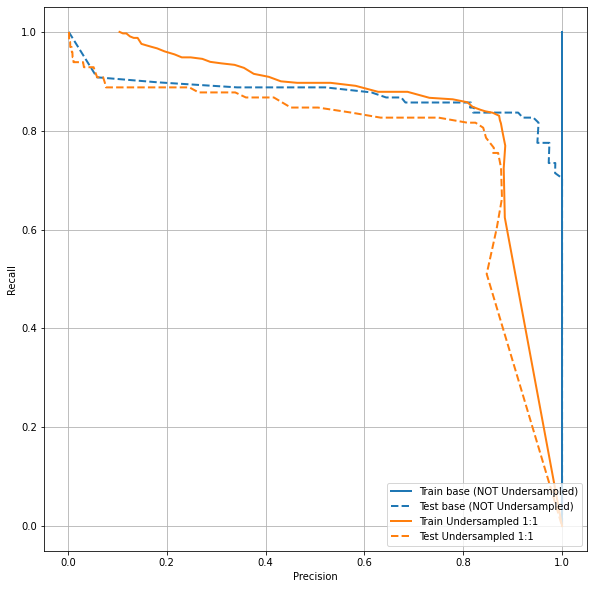

In [ ]:
plot_prc("Train base (NOT Undersampled)", train_labels, train_predictions_undersampled_proba_t, color=colors[0])
plot_prc("Test base (NOT Undersampled)", test_labels, test_predictions_undersampled_proba_t, color=colors[0], linestyle='--')

plot_prc("Train Undersampled 1:1", train_labels, train_predictions_undersampled_t1_proba_t, color=colors[1])
plot_prc("Test Undersampled 1:1", test_labels, test_predictions_undersampled_t1_proba_t, color=colors[1], linestyle='--')
plt.legend(loc='lower right');

思っていたよりFP数が多かったので、ratio=7でも性能を見てみる。

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

neg, pos = np.bincount(train_labels)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
train_f_count = neg
train_t_count = pos

under_sampling_rate = 7
sampler = RandomUnderSampler(
    sampling_strategy = {0 : int(train_t_count * under_sampling_rate), 1 : train_t_count},
    random_state = 42
)

classifier = RandomForestClassifier(
    random_state = 42,
    n_jobs = -1
)

train_res_df, train_res_labels = sampler.fit_resample(train_df, train_labels)
classifier.fit(train_res_df, train_res_labels)

Examples:
    Total: 182276
    Positive: 330 (0.18% of total)



RandomForestClassifier(n_jobs=-1, random_state=42)

Legitimate Transactions Detected (True Negatives):  56776
Legitimate Transactions Incorrectly Detected (False Positives):  88
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  85
Total Fraudulent Transactions:  98


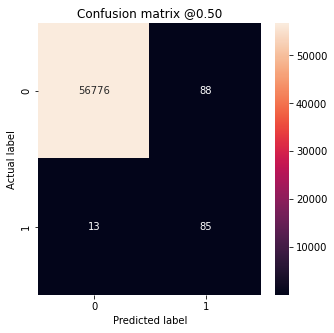

In [ ]:
train_predictions_undersampled_t2 = classifier.predict_proba(train_df)
test_predictions_undersampled_t2 = classifier.predict_proba(test_df)
train_predictions_undersampled_t2_proba_t = train_predictions_undersampled_t2.T[1]
test_predictions_undersampled_t2_proba_t = test_predictions_undersampled_t2.T[1]

plot_cm(test_labels, test_predictions_undersampled_t2_proba_t)


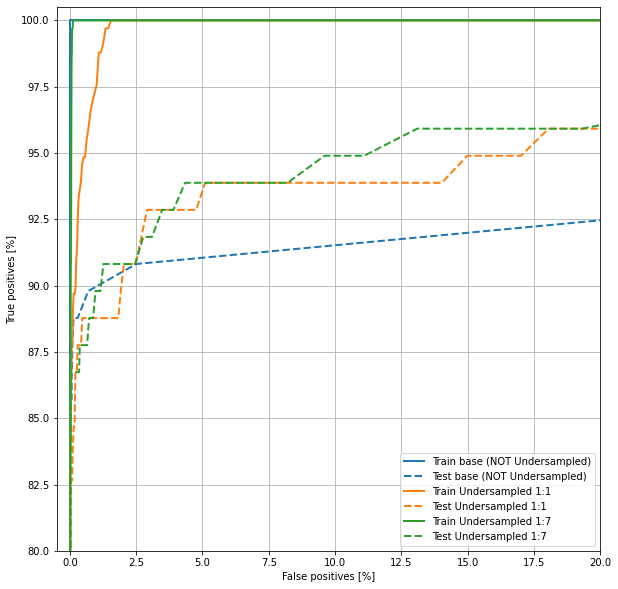

In [ ]:
plot_roc("Train base (NOT Undersampled)", train_labels, train_predictions_undersampled_proba_t, color=colors[0])
plot_roc("Test base (NOT Undersampled)", test_labels, test_predictions_undersampled_proba_t, color=colors[0], linestyle='--')

plot_roc("Train Undersampled 1:1", train_labels, train_predictions_undersampled_t1_proba_t, color=colors[1])
plot_roc("Test Undersampled 1:1", test_labels, test_predictions_undersampled_t1_proba_t, color=colors[1], linestyle='--')

plot_roc("Train Undersampled 1:7", train_labels, train_predictions_undersampled_t2_proba_t, color=colors[2])
plot_roc("Test Undersampled 1:7", test_labels, test_predictions_undersampled_t2_proba_t, color=colors[2], linestyle='--')

plt.legend(loc='lower right');


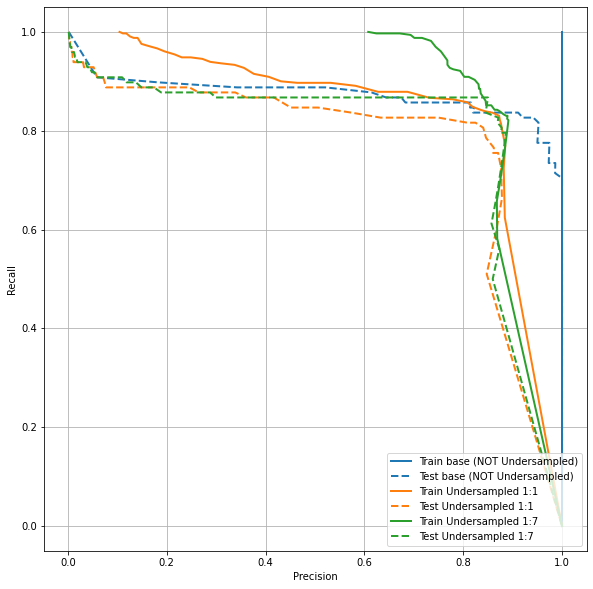

In [ ]:
plot_prc("Train base (NOT Undersampled)", train_labels, train_predictions_undersampled_proba_t, color=colors[0])
plot_prc("Test base (NOT Undersampled)", test_labels, test_predictions_undersampled_proba_t, color=colors[0], linestyle='--')

plot_prc("Train Undersampled 1:1", train_labels, train_predictions_undersampled_t1_proba_t, color=colors[1])
plot_prc("Test Undersampled 1:1", test_labels, test_predictions_undersampled_t1_proba_t, color=colors[1], linestyle='--')

plot_prc("Train Undersampled 1:7", train_labels, train_predictions_undersampled_t2_proba_t, color=colors[2])
plot_prc("Test Undersampled 1:7", test_labels, test_predictions_undersampled_t2_proba_t, color=colors[2], linestyle='--')

plt.legend(loc='lower right');